<a href="https://colab.research.google.com/github/zulfiqaralimir/Yield-Curve-and-ETF-Analysis/blob/master/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Yield Curve**
We are using Constant Maturity Treasury (CMT) yield curve.
It provide a picture of all U.S. Treasury yields at a particular date.
Closing market bid yields are used for the U.S. Treasury.
FRED API will used to pull the data, using `fredapi` Python library

In [ ]:
!pip install fredapi

In [ ]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
# Initializing the FRED API
fred = Fred(api_key='0749ccdf18180b136b399a83bcf1bced')

# List of Treasury yield series IDs
series_ids = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']

#series_ids = ['DGS10']

# Function to get data for a single series
def get_yield_data(series_id):
    data = fred.get_series(series_id, observation_start="2020-01-01", observation_end="2025-07-01")
    return data

# Get data for all series
yields_dict = {series_id: get_yield_data(series_id) for series_id in series_ids}

# Combine into a single DataFrame
yields = pd.DataFrame(yields_dict)

# Rename columns for clarity
yields.columns = ['1 Month', '3 Month', '6 Month', '1 Year', '2 Year', '3 Year', '5 Year', '7 Year', '10 Year', '20 Year', '30 Year']

In [ ]:
yields.to_csv('yields_data.csv', index=False)

In [ ]:
from google.colab import files
files.download('yields_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
yields.index = pd.to_datetime(yields.index)
yields.loc['2021-01-05']

,2021-01-05
1 Month,0.08
3 Month,0.09
6 Month,0.09
1 Year,0.10
2 Year,0.13
3 Year,0.17
5 Year,0.38
7 Year,0.66
10 Year,0.96
20 Year,1.49


Above shows all CMT Yields at specific data, as percentage.

In [ ]:
yields.isna().sum(axis = 0)

,0
1 Month,60
3 Month,60
6 Month,60
1 Year,60
2 Year,60
3 Year,60
5 Year,60
7 Year,60
10 Year,60
20 Year,60


It shows missing data. It can be attributed to holidays or market irregularites.

In [ ]:
# We can see that during the days that the 10-year is not reported,
# none maturity is reported as well.
yields[yields['10 Year'].isna() == True].sum(axis = 0)

,0
1 Month,0.0
3 Month,0.0
6 Month,0.0
1 Year,0.0
2 Year,0.0
3 Year,0.0
5 Year,0.0
7 Year,0.0
10 Year,0.0
20 Year,0.0


The Result shows No missing entries. So our data is complete and reliable for all maturities for selected time period.
Therefore, no row should be dropped or imputed for missing yield data.

###**Ploting the Yield**
It will create line graph of all yield values of all maturies over time.

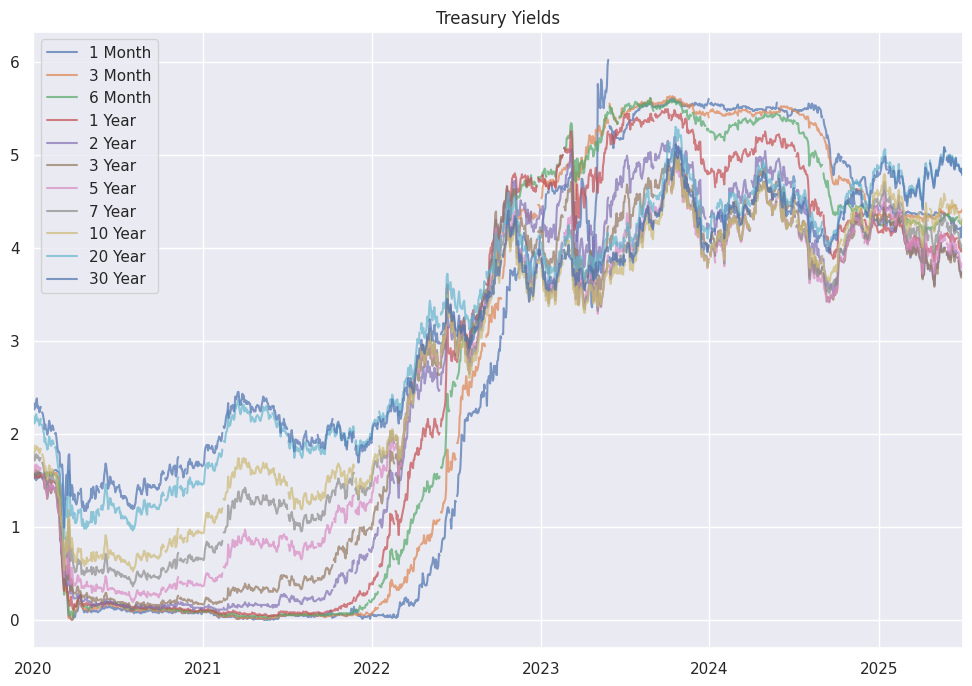

In [ ]:
# Figure 1
yields.plot(figsize=(12, 8), title='Treasury Yields', alpha=0.7) # Plot the yields
plt.show()

Figure 1 illustrate the historical behaviour of Treasury Yields for various maturities over selected period.
This plot show how long-term and short-term interest rate evolved over time and shows the movement of yield cure due to market conditions or monetary policy shifts.

Figure 1 depicts the historical trend of tretury yield curve for multiple maturities from 2020 to 2025
From 2020 to 2022, yield remained near historical low due to accomodative monetary policy during COVID-19 pandemic.
From 2022, all maturities yield curve surge sharply, reflecting aggrasive interest rate hikes by the FED to combat inflation.
The yield curves show period of steepening and flattening and at time inversion, where short-term yields exceeded long-term yields, a potential signal of recession expectations.
From 2023 to 2024, yields remained inflated but the spread between short-term and long-term narrowed, reflecting shifting market expectations about future interest rates.

##**Period of Inversion**

---



<Axes: >

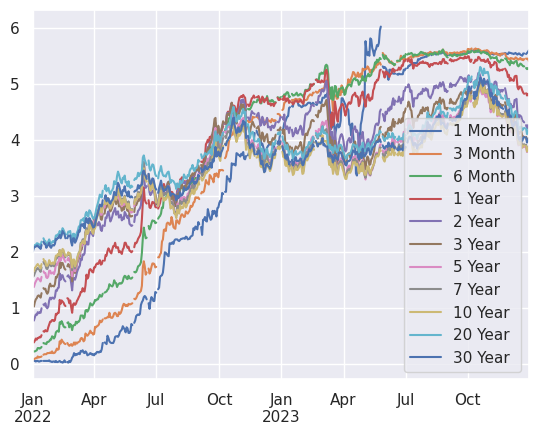

In [ ]:
yields.loc['2022':'2023'].plot()

Heighlight Inversion Period, where 2-Year > 10-Year

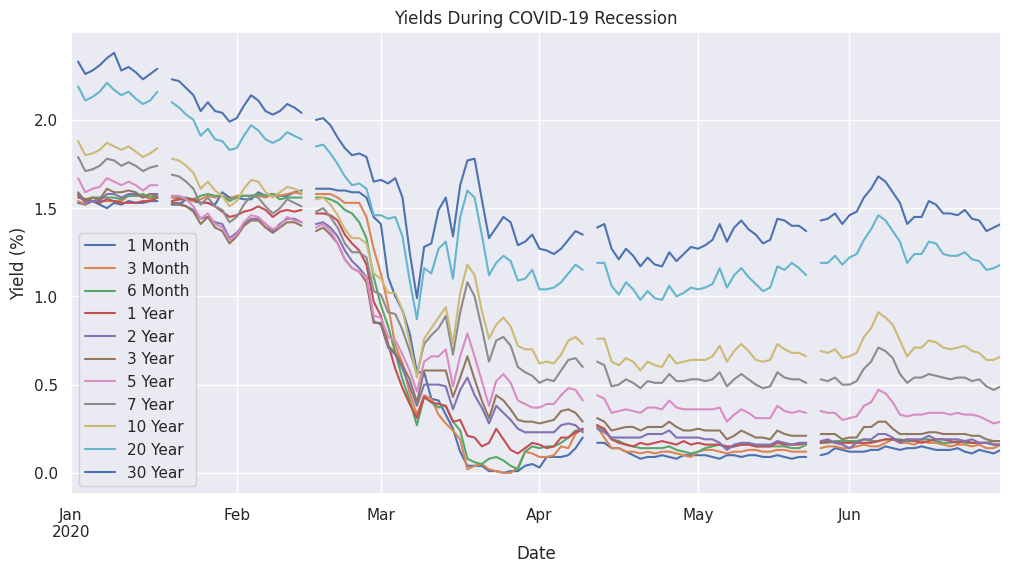

In [ ]:
yields.loc['2020-01':'2020-06'].plot(figsize=(12, 6), title='Yields During COVID-19 Recession')
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.show()

This chart shows steep drop in interest rate across all maturities in first half of 2020. This matches with COVID-19 incidence and FED decision to drop interest rate near to zero level. The entire yield curve shifted downward, depicting emergency monetary policy and sharp decline in economic activity.

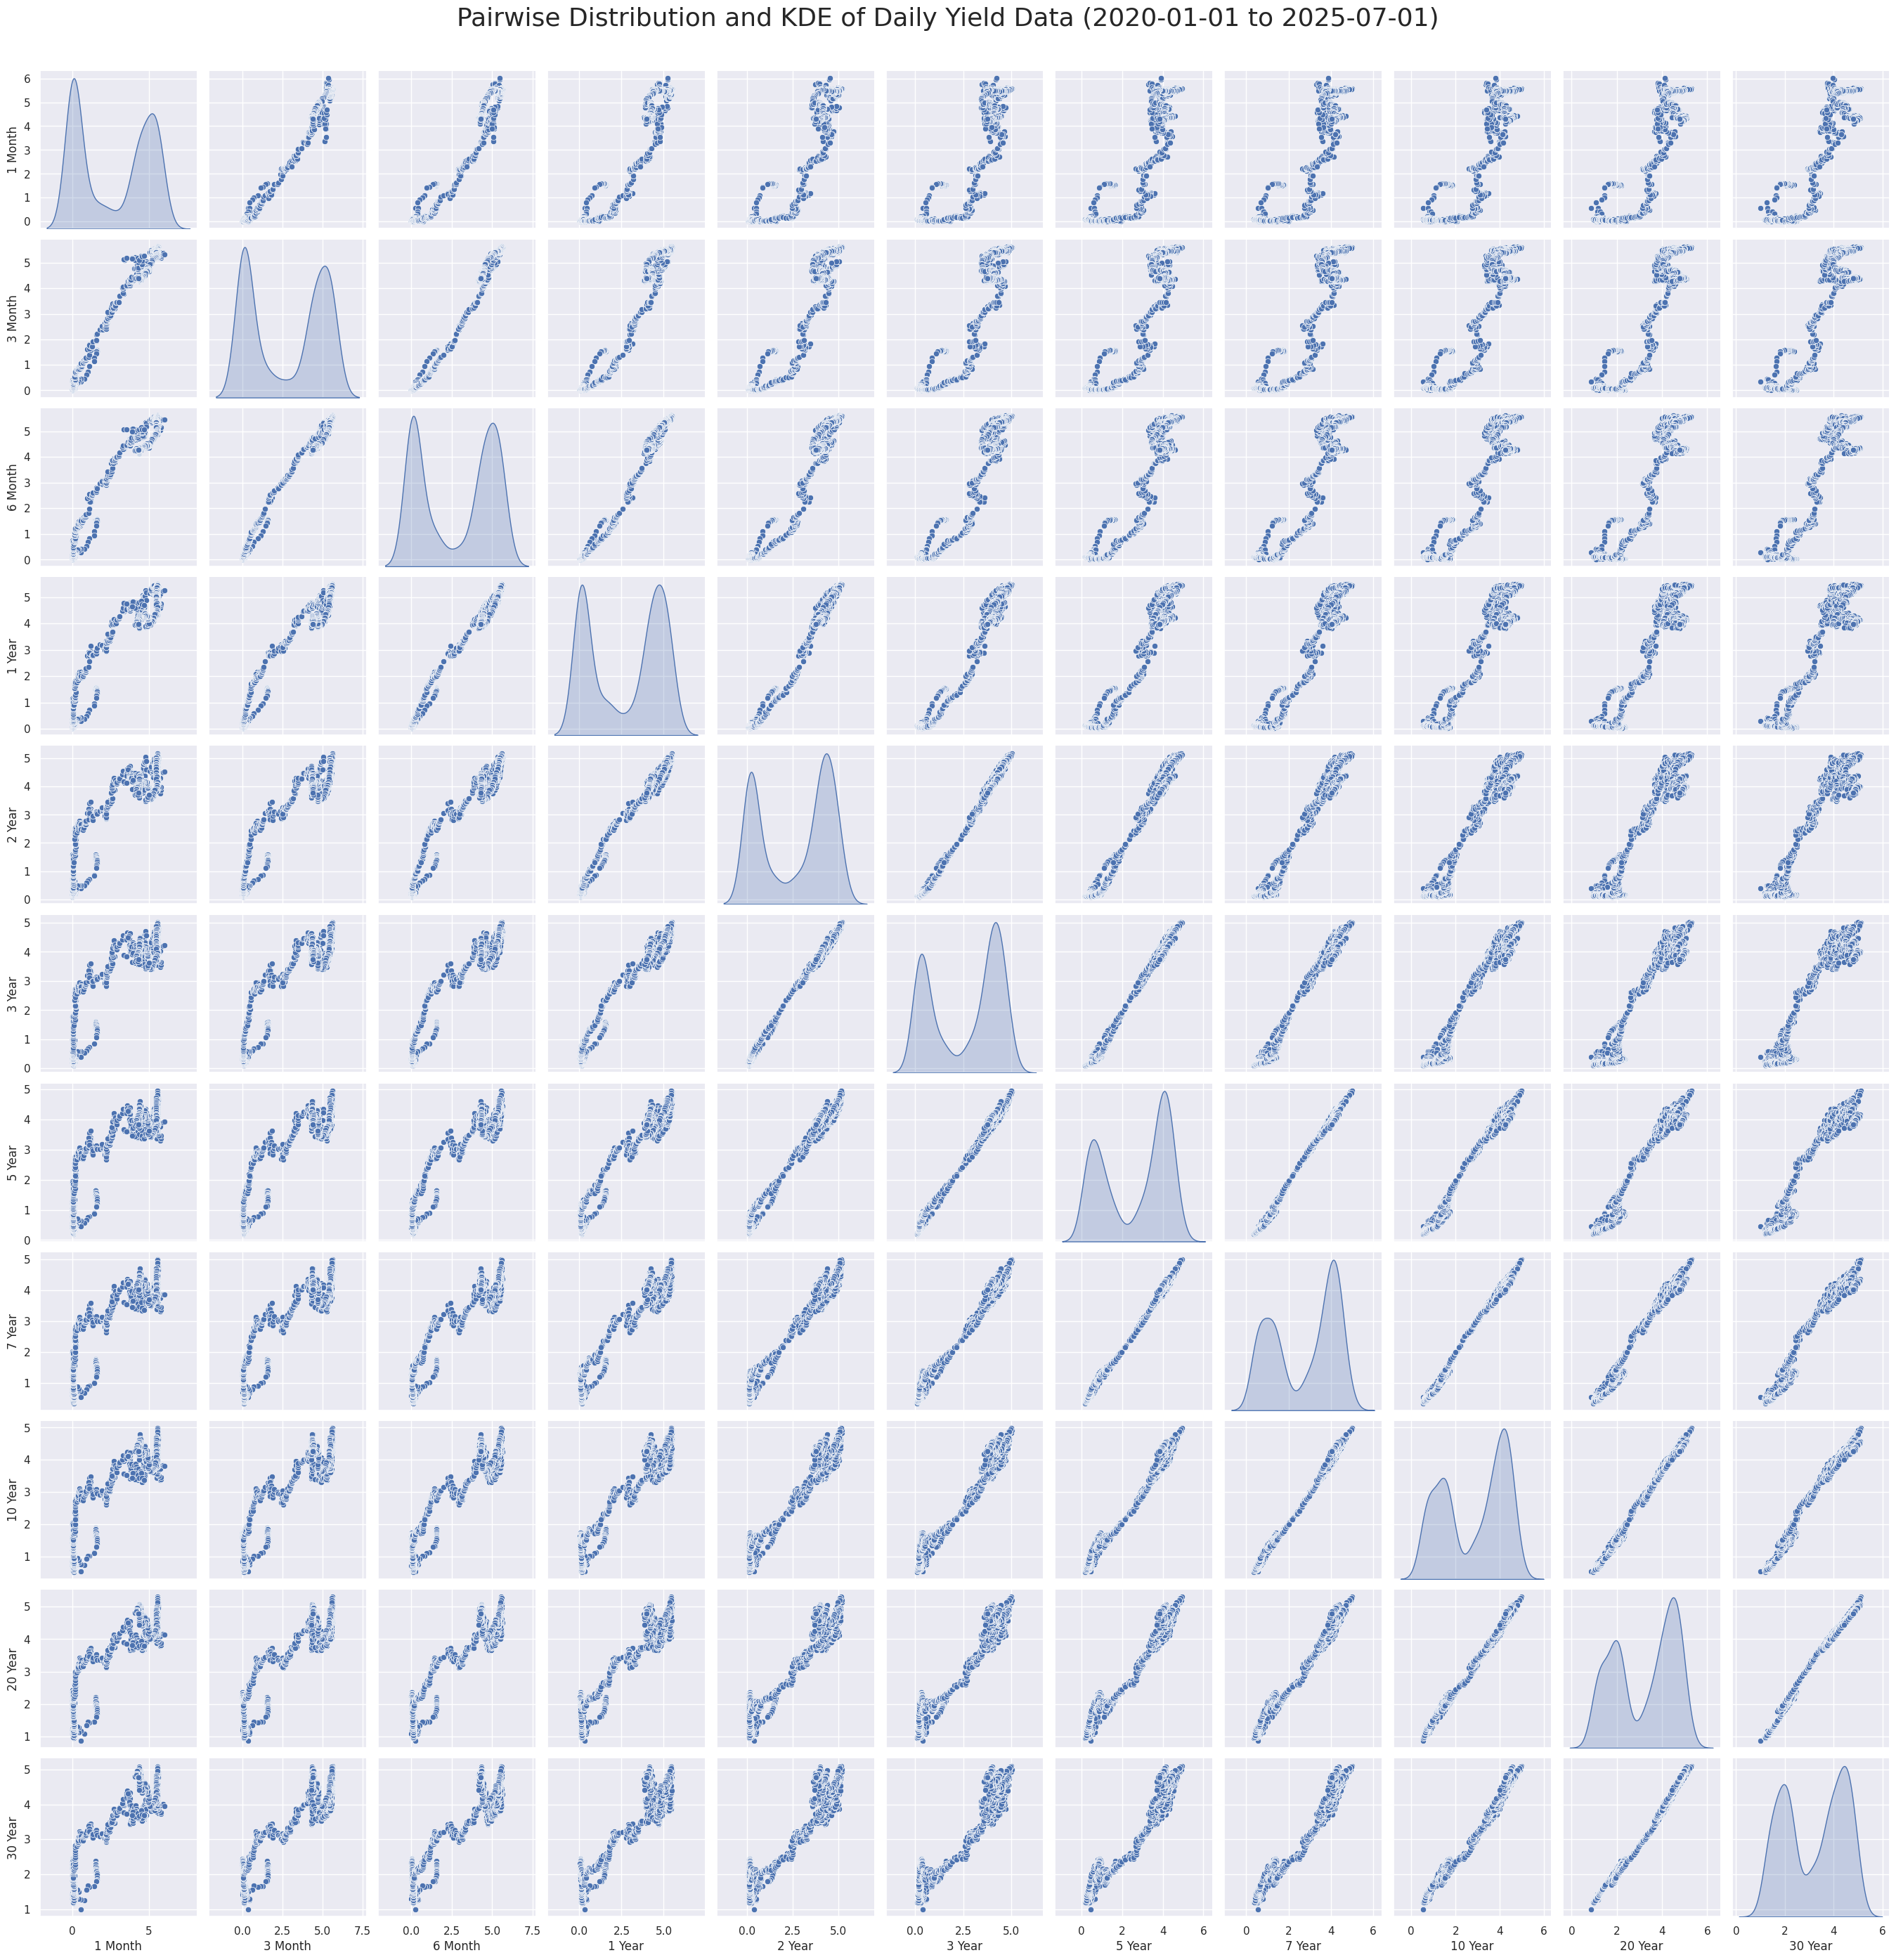

In [ ]:
# Figure 2
sns.pairplot(yields.dropna(), diag_kind='kde') # Pairplot with KDE on the diagonal
plt.suptitle("Pairwise Distribution and KDE of Daily Yield Data (2020-01-01 to 2025-07-01)",
             y=1.02, fontsize=26)
plt.show()

Figure 2 shows pairwise relationships between US treasuries yields from January 1, 2020 to July 1, 2025. The diagonal shows the kernel density estimates (KDEs) of each yield maturity, while the off-diagonal plots shows the scatter plots illustrating the correlations between different pairs of   maturities.


*   Strong Positive correlations are visible between yields of all maturities expecially those which are closed maturities.
*   KDE plot on the diagonal shows the distribution of yields across different maturities. Short-term maturities show bimodal shapes, reflecting shift from zero interest rate during COVID-19 to sharply higher interest rate post-2020.
*   These Pattern justify the use of PCA, a dimentionality Reduction Technique, since data is highly correlated and redundant across maturities.

##Let's visualize the yields at a specific date:

/tmp/ipython-input-11-180309929.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])


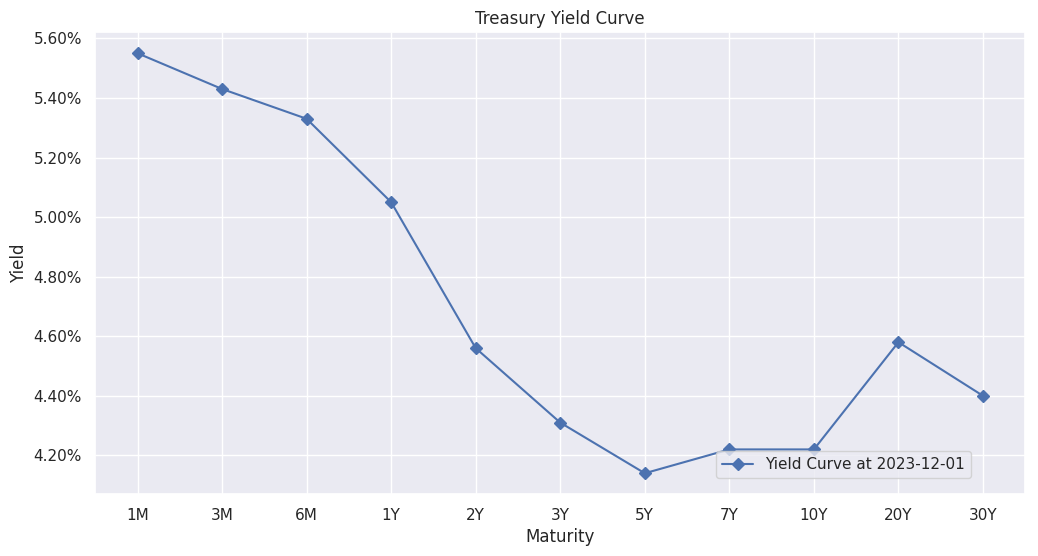

In [ ]:
# Figure 3

def plot_yield_curve(date):
    maturities = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y'] # Maturities
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(maturities, yields.loc[date], marker='D', label='Yield Curve at ' + date)

    ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])
    ax.set_xticks(range(len(maturities)))
    ax.set_xticklabels(maturities)

    # Add labels and title
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Yield')
    ax.set_title('Treasury Yield Curve')

    fig.legend(loc = [0.69, 0.14])

    # Show the plot
    plt.grid(True)
    plt.show()

plot_yield_curve('2023-12-01')

**Figure 3** illustrate the US Treasury Yield Curve on December 1, 2023, a period when the curve was significantly inverted.
Short-term yield (1M to 1Y) were above 5%, reflecting aggresive FED rate hike amid at controlling inflation.
Meanwhile Medium and Long-term yields were much lower, with dip around 5-year maturity and only a modest rise at 20-30 years.
The inversion signals that market were anticipating economic slowdown or potential recession, expecting future rate cuts.

/tmp/ipython-input-11-180309929.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])


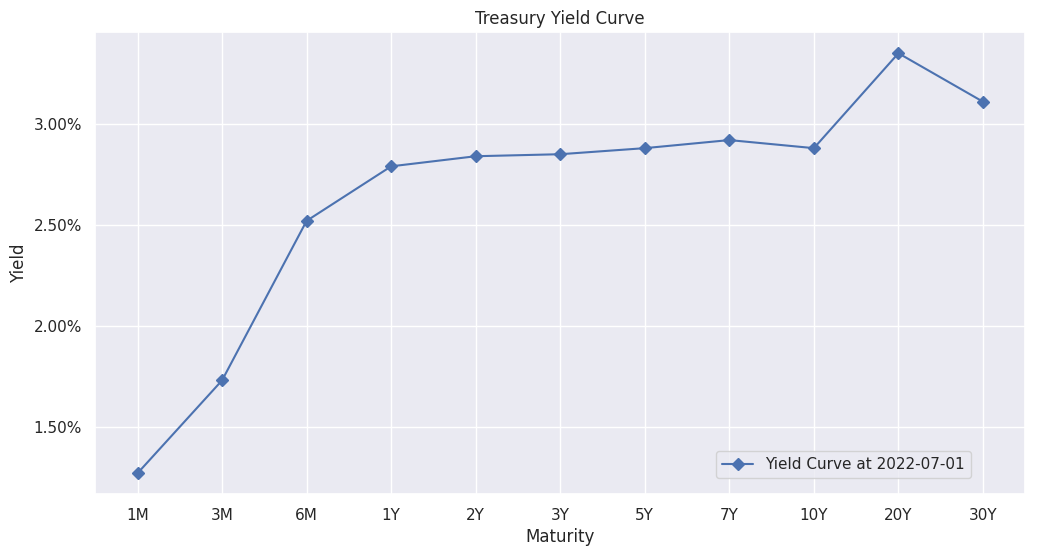

/tmp/ipython-input-11-180309929.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])


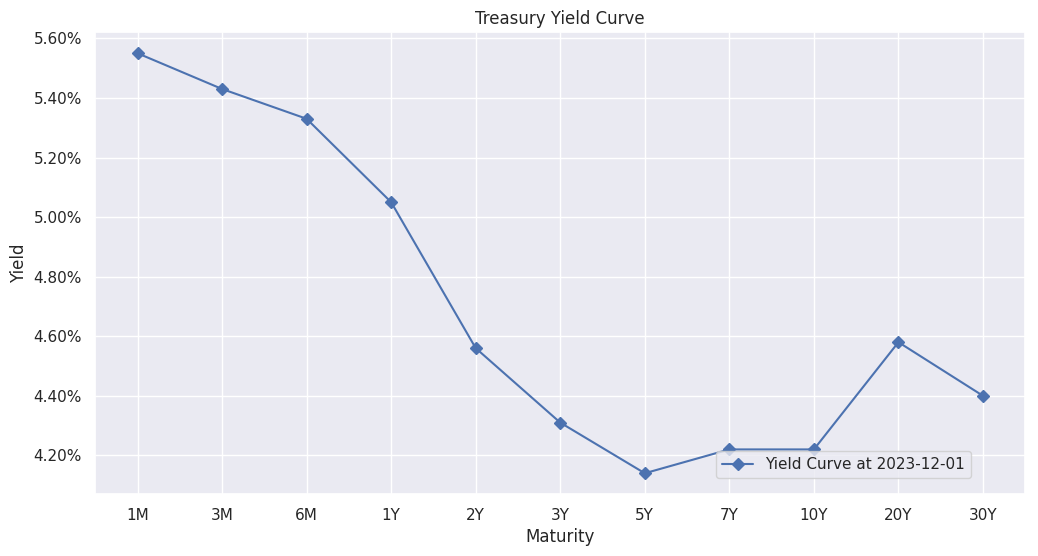

In [ ]:
plot_yield_curve('2022-07-01')
plot_yield_curve('2023-12-01')


On July 1, 2022, the Treasury yield curve was relatively flat, with short- and long-term yields very close to each other.
This reflects a transitional phase in monetary policy, where the Federal Reserve had begun raising short-term interest rates but long-term market expectations had not yet fully adjusted.

By contrast, on December 1, 2023, the curve was inverted, with short-term yields (e.g., 1-month) significantly higher than 10- or 30-year yields.
This inversion often precedes economic slowdowns, as investors expect interest rates to fall in the future due to a potential recession.

#**Understanding the Yield Curve Shape**
When analyzing yield curves (like in Figure 3 and Last one), we focus on two primary characteristics:

#1. **Level**
- Represents how high or low yields are across all maturities.

- A high level = high interest rates across the board.

- A low level = generally low rates (often seen during recessions or crises).

#2. **Slope**
- Measures how much yields change from short-term to long-term.

- A normal (steep) curve slopes upward (long-term rates > short-term).

- A flat curve suggests uncertainty or transition periods.

- An inverted curve (short-term > long-term) often signals a possible upcoming recession.

#3. **Curvature**
- Tells how the middle of the curve behaves (e.g., bulging up or down).

#**Yield Curve on 2022-01-01 (Flat)**
- **Level:** Yields are around 1.0% to 1.5%, indicating a relatively low interest rate environment.

- **Slope:** The curve is flat, meaning short-term and long-term rates are similar. This often happens during transitions or policy uncertainty.

#**Yield Curve on 2023-12-01 (Inverted)**
- **Level:** Yields are high, mostly between 4.2% to 5.5%—showing a period of tight monetary policy.

- **Slope:** The curve is inverted—short-term yields (1M, 3M) are higher than long-term (10Y, 30Y). This is often seen as a signal of upcoming recession.

#**Normal Yield Curve (e.g., 2021-01-04)**
- **Level:** Low yields (under 1%) reflect loose monetary policy (e.g., during COVID-19 recovery).

- **Slope:** Upward — long-term yields are higher than short-term yields.

- **Investor Behavior:**

 -  Investors expect economic growth and inflation to rise gradually.

 - They are comfortable holding long-term bonds for better yields.

 - There's less urgency to move funds, investors feel relatively secure.

#**Inverted Yield Curve (e.g., 2023-12-01)**
- **Level:** Higher overall level (above 5%) due to rate hikes.

- **Slope:** Downward — short-term yields exceed long-term yields.

- **Investor Behavior:**

 - Often seen as a signal of recession: investors expect future rate cuts.

 - Many shift into long-term bonds to lock in higher yields before cuts arrive.

 - Flight to safety: investors prefer long-term treasuries, expecting risk in the short term.

 - Borrowing drops: higher short-term rates make it expensive to finance short-term projects.



/tmp/ipython-input-13-3398729853.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_rate_hike = rate_hike_period.resample('M').last()


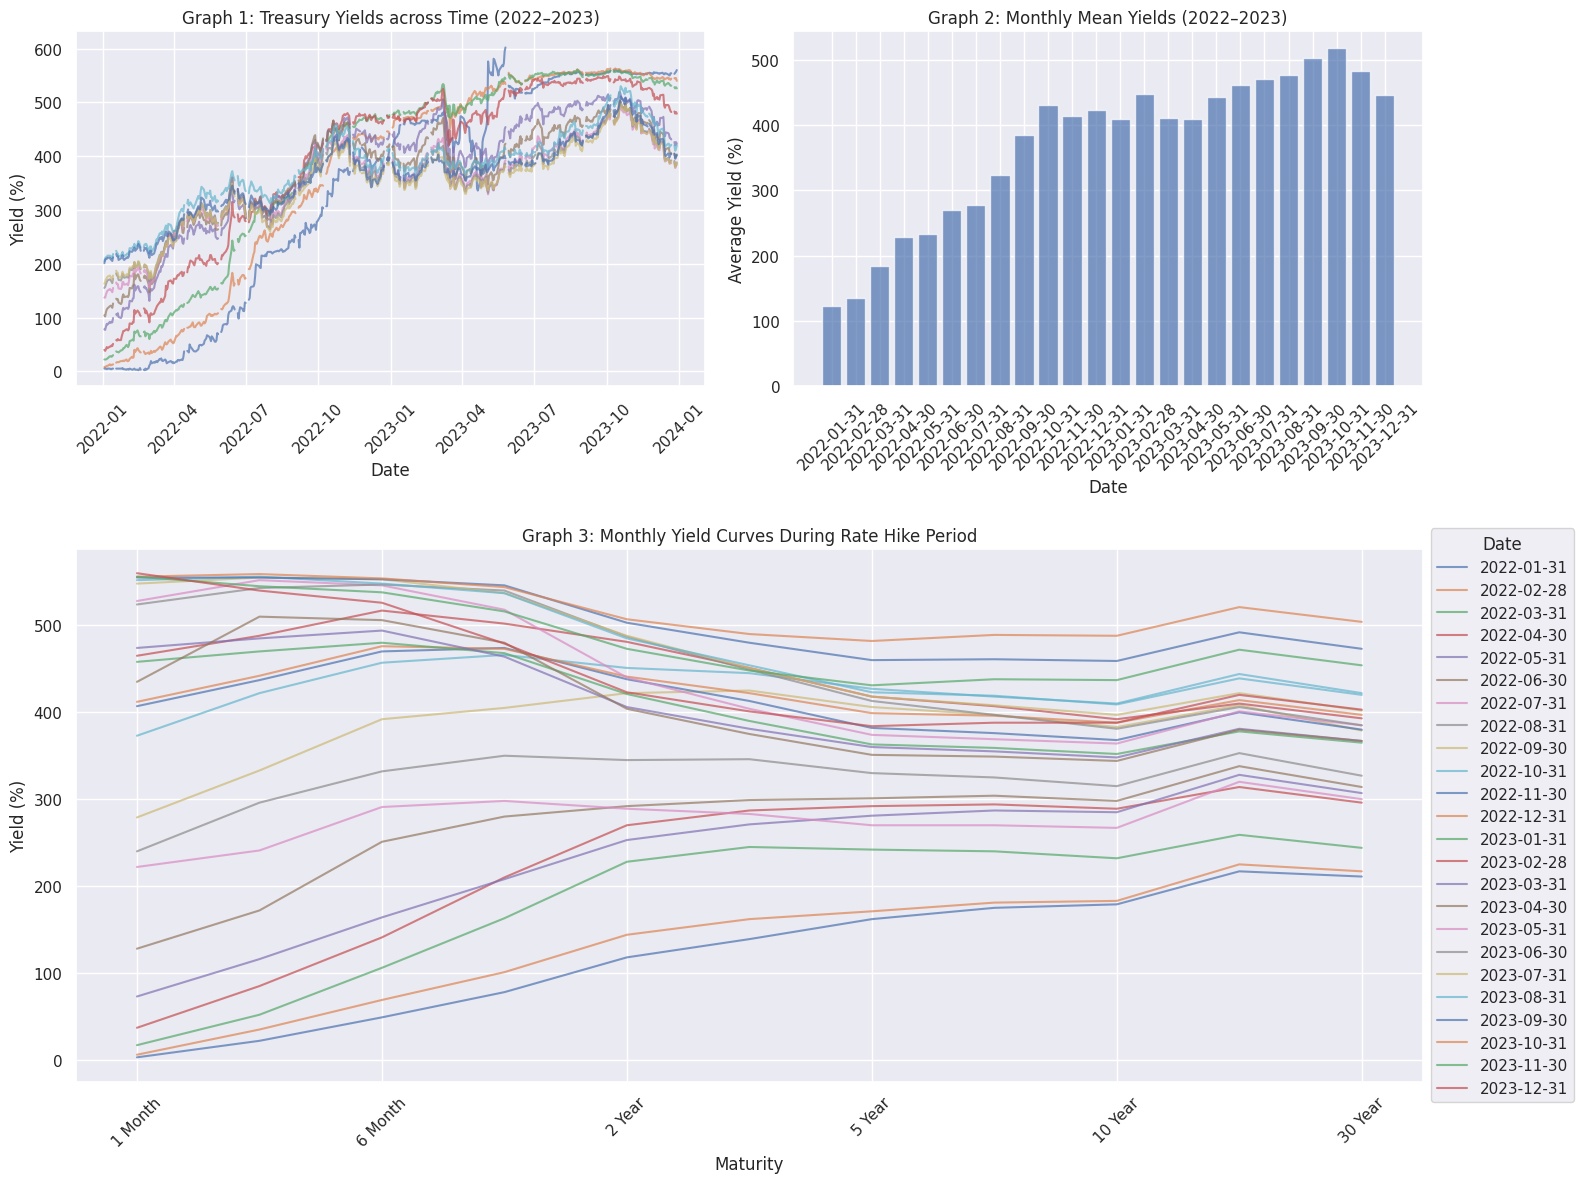

In [ ]:
# Figure 4

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

# Filter for the rate hike period
rate_hike_period = yields.loc['2022-01-01':'2023-12-31'].copy()
rate_hike_period *= 100  # Convert to percentage

# Monthly snapshots
monthly_rate_hike = rate_hike_period.resample('M').last()
monthly_rate_hike_ticks = monthly_rate_hike.index.strftime('%Y-%m-%d')

# Create the figure with 3 graphs
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, height_ratios=[1, 1.5])

# ─── Graph 1: Daily Treasury Yields ─────────────────────
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(rate_hike_period, alpha=0.7)
ax1.set_title('Graph 1: Treasury Yields across Time (2022–2023)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Yield (%)')
ax1.tick_params(axis='x', rotation=45)

# ─── Graph 2: Monthly Mean Yields ───────────────────────
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(monthly_rate_hike_ticks, monthly_rate_hike.mean(axis=1), alpha=0.7)
ax2.set_title('Graph 2: Monthly Mean Yields (2022–2023)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Yield (%)')
ax2.tick_params(axis='x', rotation=45)

# ─── Graph 3: Yield Curves (End of Each Month) ──────────
ax3 = fig.add_subplot(gs[1, :])
for i in range(len(monthly_rate_hike)):
    date = monthly_rate_hike_ticks[i]
    monthly_rate_hike.iloc[i, :].plot(ax=ax3, alpha=0.7, label=date)

ax3.set_title('Graph 3: Monthly Yield Curves During Rate Hike Period')
ax3.set_xlabel('Maturity')
ax3.set_ylabel('Yield (%)')
ax3.legend(title='Date', loc='center left', bbox_to_anchor=(1, 0.5))
ax3.tick_params(axis='x', rotation=45)

# Layout adjustment
plt.tight_layout()
plt.show()


#**Figure 4: Yield Curve Trends During the Rate Hike Cycle**

##**Graph 1: Treasury Yields across Time (2022–2023)**

- **Description**: This line plot shows how yields for various maturities (1M to 30Y) have changed over time.

- **Interpretation**: All maturity yields rose significantly in 2022, peaking in late 2023, reflecting the Fed's aggressive monetary tightening.

##**Graph 2: Monthly Mean Yields (2022–2023)**

- **Description:** This bar chart presents the monthly average yields over the period.

- **Interpretation:** The increasing trend in the bar heights confirms rising average interest rates, peaking towards the end of 2023.

##**Graph 3: Monthly Yield Curves During Rate Hike Period**

- **Description:** This multi-line plot displays yield curves at the end of each month.

- **Interpretation:**

 - **Early in 2022:** Upward-sloping curves, indicating normal economic conditions.

 - **Mid to late 2022:** Curves begin to flatten, especially between short and long-term maturities.

 - **2023:** Some curves show inversion, a potential signal of recessionary expectations.

/tmp/ipython-input-14-3848371844.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-07-01')
[*********************100%***********************]  1 of 1 completed


S&P 500 Columns: MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


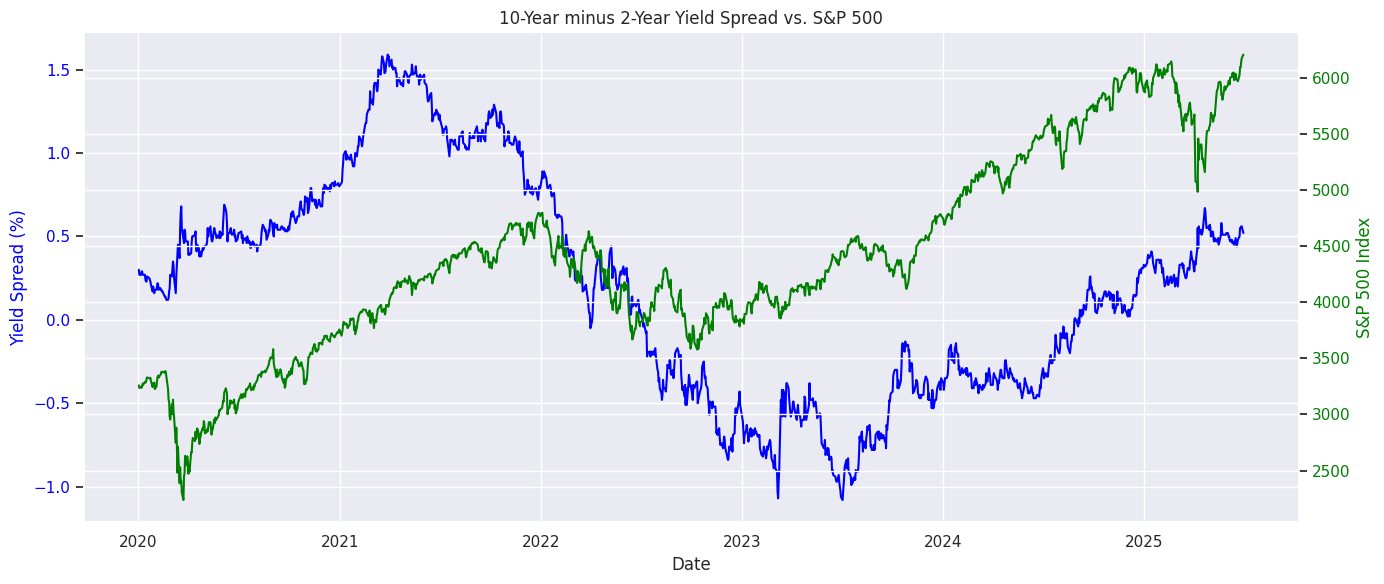

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Compute Yield Spread
spread = yields['10 Year'] - yields['2 Year']
spread.name = '10Y - 2Y Spread'

# Download S&P 500 Data
sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-07-01')
print("S&P 500 Columns:", sp500.columns)

# Handle MultiIndex safely and use 'Close' instead of 'Adj Close'
if isinstance(sp500.columns, pd.MultiIndex):
    sp500 = sp500['Close']['^GSPC']
else:
    sp500 = sp500['Close']

sp500.name = 'S&P 500'

# Merge and Align
combined = pd.concat([spread, sp500], axis=1).dropna()

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left Axis: Yield Spread
ax1.plot(combined.index, combined['10Y - 2Y Spread'], color='blue', label='10Y - 2Y Spread')
ax1.set_ylabel('Yield Spread (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Date')

# Right Axis: S&P 500
ax2 = ax1.twinx()
ax2.plot(combined.index, combined['S&P 500'], color='green', label='S&P 500')
ax2.set_ylabel('S&P 500 Index', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('10-Year minus 2-Year Yield Spread vs. S&P 500')
plt.grid(True)
plt.tight_layout()
plt.show()

#**Figure 5: 10-Year Minus 2-Year Yield Spread vs. S&P 500 (2020–2025)**
This figure illustrates the relationship between the 10-year minus 2-year Treasury yield spread (left axis, blue) and the S&P 500 index (right axis, green) over the period from January 2020 to July 2025.

##**Key Observations:**
- **Yield Curve Inversion:** The yield spread turns negative around mid-2022, indicating an inverted yield curve — a typical warning sign of economic slowdown or recession.

- **Market Dynamics:** The S&P 500 reacts to this inversion with a period of volatility and stagnation through 2022–2023, before recovering into 2024–2025.

- **Flattening Dynamics:** The flattening and subsequent inversion of the yield curve can be clearly observed here, this supports the theoretical **link between yield curve slope and investor sentiment**.

- **Investor Behavior:** When the spread narrows or inverts, investors often move away from risky assets like equities, expecting lower future growth. This aligns with the dip in the S&P 500 index during the inversion phase.



/tmp/ipython-input-15-1346221364.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-07-01')
[*********************100%***********************]  1 of 1 completed


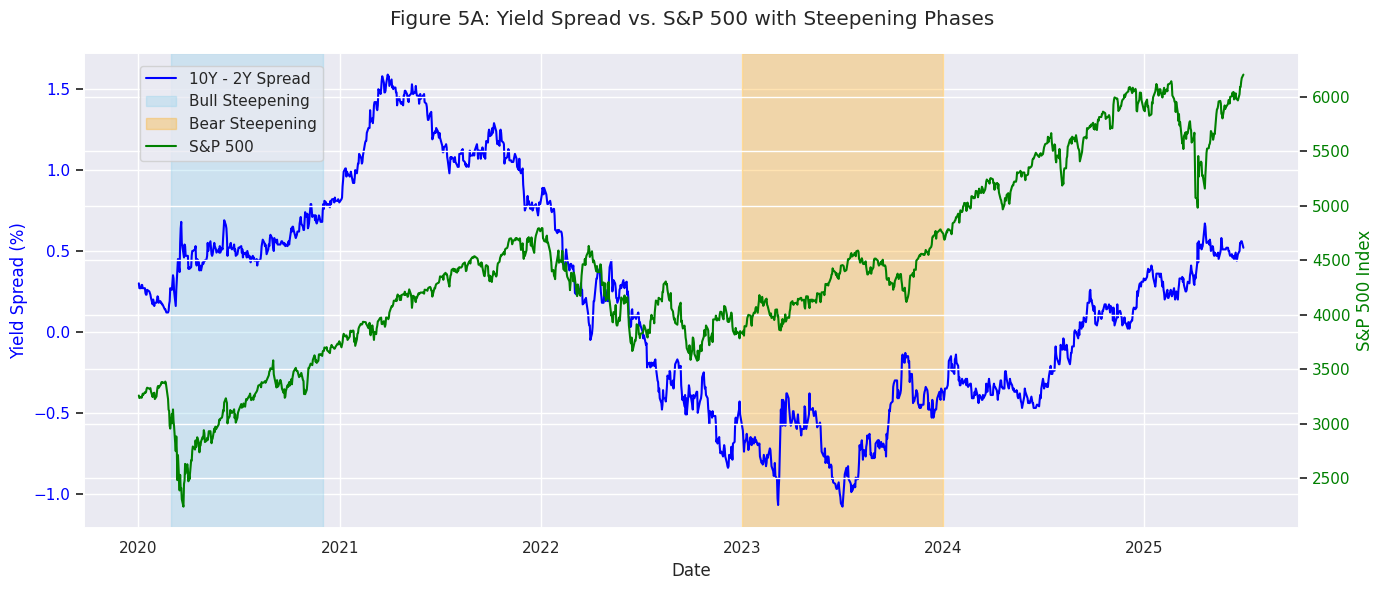

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Compute Yield Spread
spread = yields['10 Year'] - yields['2 Year']
spread.name = '10Y - 2Y Spread'

# Download S&P 500 Data
sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-07-01')

# Use 'Close' safely
if isinstance(sp500.columns, pd.MultiIndex):
    sp500 = sp500['Close']['^GSPC']
else:
    sp500 = sp500['Close']
sp500.name = 'S&P 500'

# Merge and align
combined = pd.concat([spread, sp500], axis=1).dropna()

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left axis: Yield Spread
ax1.plot(combined.index, combined['10Y - 2Y Spread'], color='blue', label='10Y - 2Y Spread')
ax1.axvspan('2020-03-01', '2020-12-01', color='skyblue', alpha=0.3, label='Bull Steepening')
ax1.axvspan('2023-01-01', '2024-01-01', color='orange', alpha=0.3, label='Bear Steepening')
ax1.set_ylabel('Yield Spread (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Date')

# Right axis: S&P 500
ax2 = ax1.twinx()
ax2.plot(combined.index, combined['S&P 500'], color='green', label='S&P 500')
ax2.set_ylabel('S&P 500 Index', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and legend
fig.suptitle('Figure 5A: Yield Spread vs. S&P 500 with Steepening Phases')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.tight_layout()
plt.show()

#**Figure 5A illustrates bull and bear steepening in the yield curve.**

During the bull steepening period (2020), short-term yields dropped rapidly due to the Fed's aggressive rate cuts in response to the COVID-19 crisis, while long-term yields declined less. This steepened the curve as seen by the rising blue line. The S&P 500 initially fell but quickly recovered, reflecting investor optimism backed by monetary support.

In contrast, the bear steepening phase (2023) occurred as inflation concerns grew and the Fed slowed its hiking pace. Long-term yields increased while short-term ones remained elevated or started falling, steepening the curve again but in a different way.

These dynamics reflect how market expectations shift between fear-driven monetary easing and growth/inflation-driven rate normalization.

/tmp/ipython-input-16-945413422.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-07-01')
[*********************100%***********************]  1 of 1 completed


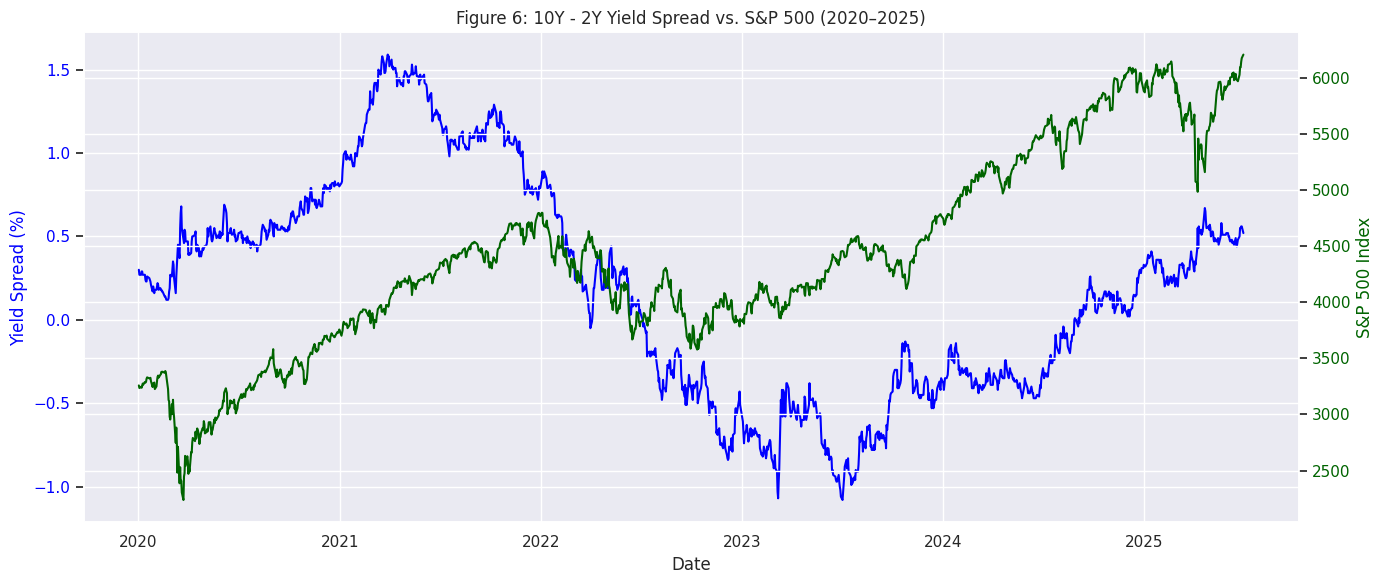

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# --- Compute the Yield Spread ---
spread = yields['10 Year'] - yields['2 Year']
spread.name = '10Y - 2Y Spread'

# --- Download S&P 500 data (2020–2025) ---
sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-07-01')

# Extract 'Close' price safely
if isinstance(sp500.columns, pd.MultiIndex):
    sp500 = sp500['Close']['^GSPC']
else:
    sp500 = sp500['Close']
sp500.name = 'S&P 500'

# --- Merge Spread and S&P 500 ---
combined = pd.concat([spread, sp500], axis=1).dropna()

# --- Plot: Dual Axis ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left y-axis: Yield Spread
ax1.plot(combined.index, combined['10Y - 2Y Spread'], color='blue', label='10Y - 2Y Spread')
ax1.set_ylabel('Yield Spread (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Date')

# Right y-axis: S&P 500
ax2 = ax1.twinx()
ax2.plot(combined.index, combined['S&P 500'], color='darkgreen', label='S&P 500')
ax2.set_ylabel('S&P 500 Index', color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')

# Title
plt.title('Figure 6: 10Y - 2Y Yield Spread vs. S&P 500 (2020–2025)')
plt.grid(True)
plt.tight_layout()
plt.show()


This figure demonstrates the importance of the 10-year minus 2-year yield spread as an **economic signal**, alongside the performance of the S&P 500 index.

###**Key Observations**
**Normal Slope (Positive Spread):**

In 2020 to mid-2022, the yield spread remains **positive**. This reflects typical market expectations, **Long-term yields higher than short-term ones**, signaling **stable growth**.

**Flattening and Inversion:**

By late 2022, the spread turns **negative**, the curve **inverts**. This is a classic warning sign of **recession** expectations. Short-term interest rates surpass long-term rates, often due to aggressive Fed rate hikes targeting inflation.

**Equity Market Impact:**

While the S&P 500 initially rises (post-COVID recovery), it flattens and experiences volatility as the yield curve inverts. This suggests that **equity markets react with a lag to bond market signals**.

#**Conclusion**

Through hands-on analysis and visualization using Python and the **FRED API**, we examined the dynamics of the U.S. Treasury yield curve from 2020 to 2025. By analyzing historical data, we explored how components such as the level and slope of the curve evolve over time, and how these shifts relate to broader economic conditions and market expectations.